In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim import corpora
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import itertools

In [19]:
df = pd.read_csv('../data/dataHasilPreprocessing/hasilPreprocessing1.csv')
df

,Ulasan,Sentimen
0,ulas,Negatif
1,NaN,Negatif
2,bahan aja warna navy nya beda,Negatif
3,kasih catat order warna kuning navy baca kirim...,Negatif
4,kecil,Negatif
...,...,...
990,barang selamat terima kasih bahan celana nya s...,Negatif
991,kecil,Negatif
992,pesan cuna barang rusak coba konfirmasi tanggap,Negatif
993,karet pinggang nya kencang,Negatif


In [20]:
df = df.drop_duplicates(subset=['Ulasan'])

In [21]:
df = df.dropna()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 0 to 994
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ulasan    947 non-null    object
 1   Sentimen  947 non-null    object
dtypes: object(2)
memory usage: 22.2+ KB


In [23]:
ulasan = df['Ulasan']
sentimen = df['Sentimen']

In [24]:
tokenized_reviews = [review.lower().split() for review in ulasan]
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]
hdp_model = HdpModel(corpus, dictionary)
topic_distributions = [hdp_model[doc] for doc in corpus]

In [25]:
num_topics = 5 

X = []
for dist in topic_distributions:
    feat = [0] * num_topics
    for topic, weight in dist:
        if topic < num_topics:
            feat[topic] = weight
    X.append(feat)

In [26]:
main_topics = [max(dist, key=lambda x: x[1])[0] if dist else None for dist in topic_distributions]
data = {'aspect': main_topics, 'sentimen': sentimen, 'ulasan': ulasan}
df_new = pd.DataFrame(data)

df_new

,aspect,sentimen,ulasan
0,88,Negatif,ulas
2,110,Negatif,bahan aja warna navy nya beda
3,88,Negatif,kasih catat order warna kuning navy baca kirim...
4,97,Negatif,kecil
5,116,Negatif,tau layan
...,...,...,...
989,11,Negatif,cocok
990,37,Negatif,barang selamat terima kasih bahan celana nya s...
992,86,Negatif,pesan cuna barang rusak coba konfirmasi tanggap
993,62,Negatif,karet pinggang nya kencang


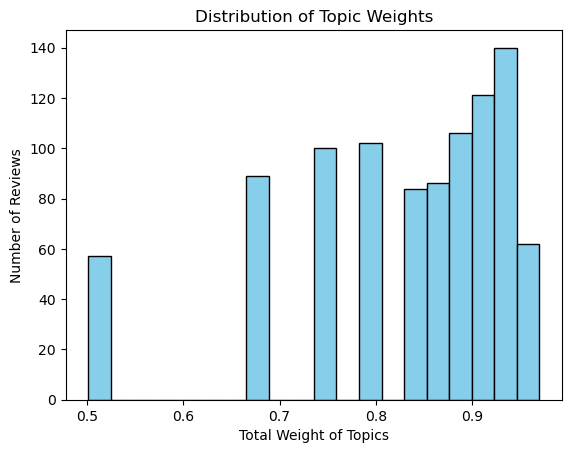

In [27]:
topic_weights = [sum(weight for _, weight in dist) for dist in topic_distributions]
plt.hist(topic_weights, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Topic Weights')
plt.xlabel('Total Weight of Topics')
plt.ylabel('Number of Reviews')
plt.show()

In [28]:
# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, sentimen, test_size=0.2, random_state=42)

In [29]:
# Melatih model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [30]:
# Memprediksi sentimen pada data uji
y_pred = svm_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

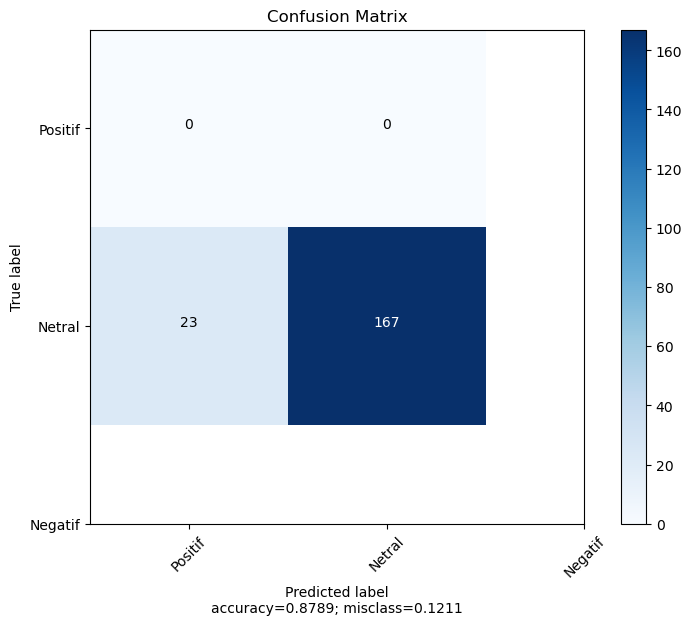

In [32]:
plot_confusion_matrix(cm           = confusion_matrix(y_pred,y_test),
                      normalize    = False,
                      target_names = ['Positif', 'Netral', 'Negatif'],
                      title        = "Confusion Matrix")

In [33]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8789473684210526

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        23
     Positif       0.88      1.00      0.94       167

    accuracy                           0.88       190
   macro avg       0.44      0.50      0.47       190
weighted avg       0.77      0.88      0.82       190



c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier